In [81]:
!uv add numpy scipy matplotlib seaborn pandas scikit-learn ipynbname

Resolved 57 packages in 4ms
Audited 53 packages in 7ms


In [82]:
from pathlib import Path

runtime_path = Path.cwd()
DATA_DIR = runtime_path / ".." / "data"

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", palette="pastel")

---

# Data Information

In [84]:
df = pd.read_csv(DATA_DIR / "Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [86]:
df.select_dtypes(include="object").describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [87]:
df.select_dtypes(exclude="object").describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


---

## Step 1: Handling Missing Values
1. Identify columns that contain missing values.
2. Choose an appropriate strategy for each case:
    - Numerical features: mean or median imputation
    - Categorical features: mode imputation
3. Explain briefly why you chose each method.

In [88]:
# Find the columns which contains missing values
for col in df.columns:
    if df[col].isnull().any():
        print(f"found column with missing values: {col}")

found column with missing values: Age
found column with missing values: Cabin
found column with missing values: Embarked


### Handling missing values in `Age`

In [89]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Because the proportion of missing values is small (<20%), I chose to impute the missing values using a statistical measure from the Age column.

<Axes: xlabel='Age'>

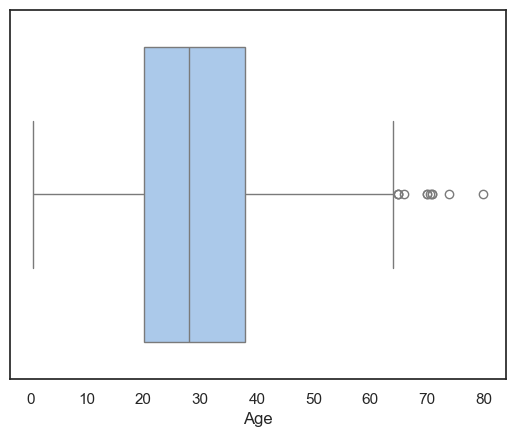

In [90]:
sns.boxplot(df, x="Age")

According to the boxplot diagram, the values in the `Age` column exhibit a left-skewed distribution and contain many outliers; since the mean would be influenced by these outliers, I chose to use the median to impute missing values.

In [91]:
# Impute missing values of `Age` column with median
df["Age_Clean"] = df["Age"].fillna(df["Age"].median())

In [92]:
# Check there is no NaN
age_clean_has_nan = df["Age_Clean"].isna().any()
print(f"`Age_Clean` has NaN? {age_clean_has_nan}.")

# Show at most 5 rows that `Age` is NaN and `Age_Clean` is not NaN
# to check whether the missing values are filled by median
filtered_df = df[df["Age"].isna() & df["Age_Clean"].notna()][["PassengerId", "Age", "Age_Clean"]]
filtered_df.head(5)

`Age_Clean` has NaN? False.


,PassengerId,Age,Age_Clean
5,6,NaN,28.0
17,18,NaN,28.0
19,20,NaN,28.0
26,27,NaN,28.0
28,29,NaN,28.0


### Handling missing values in `Cabin`

In [93]:
df["Cabin"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
204 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [94]:
df["Cabin"].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

Because missing values account for the majority (>77%), imputing them with any statistical measure would distort the original data distribution; therefore, I chose to fill the missing values with a literal value, creating a new category.

In [95]:
df["Cabin_Clean"] = df["Cabin"].fillna("Unknown")

In [96]:
# Check there is no NaN
cabin_clean_has_nan = df["Cabin_Clean"].isna().any()
print(f"`Cabin_Clean` has NaN? {cabin_clean_has_nan}.")

# Show at most 5 rows that `Cabin` is NaN and `Cabin_Clean` is not NaN
# to check whether the missing values are filled by median
filtered_df = df[df["Cabin"].isna() & df["Cabin_Clean"].notna()][["PassengerId", "Cabin", "Cabin_Clean"]]
filtered_df.head(5)

`Cabin_Clean` has NaN? False.


,PassengerId,Cabin,Cabin_Clean
0,1,NaN,Unknown
2,3,NaN,Unknown
4,5,NaN,Unknown
5,6,NaN,Unknown
7,8,NaN,Unknown


### Handling missing values in `Embarked`

In [97]:
df["Embarked"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Embarked
Non-Null Count  Dtype 
--------------  ----- 
889 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [98]:
df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

Because there are only two missing values (≪1%), I consider the impact of imputing them with any statistical measure on the original data to be negligible; since this column is categorical, I chose to use the mode for imputation.

In [99]:
df["Embarked_Clean"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

In [100]:
# Check there is no NaN
embarked_clean_has_nan = df["Embarked_Clean"].isna().any()
print(f"`Cabin_Clean` has NaN? {embarked_clean_has_nan}.")

# Show at most 5 rows that `Embarked` is NaN and `Embarked_Clean` is not NaN
# to check whether the missing values are filled by median
filtered_df = df[df["Embarked"].isna() & df["Embarked_Clean"].notna()][["PassengerId", "Embarked", "Embarked_Clean"]]
filtered_df.head(5)

`Cabin_Clean` has NaN? False.


,PassengerId,Embarked,Embarked_Clean
61,62,NaN,S
829,830,NaN,S


---

# Step 2: Noise Detection and Handling
1. Select one numerical feature.
2. Add artificial noise (small random variations) to this feature.
3. Apply a simple noise-handling technique, such as:
    - Moving average
    - Smoothing by aggregation
4. Compare the feature before and after noise handling.

The Fare column contains continuous values; therefore, noise handling was applied to this column.

In [101]:
np.random.seed(42)  # set for repeatability test

In [102]:
# Noise intensity is adaptively scaled to the magnitude of the column.
sigma = df["Fare"].std()
df["Fare_with_Noise"] = df["Fare"] + np.random.normal(scale=0.01 * sigma, size=len(df))

In [103]:
(df[["PassengerId", "Fare", "Fare_with_Noise"]]).head(10)

,PassengerId,Fare,Fare_with_Noise
0,1,7.2500,7.496834
1,2,71.2833,71.214592
2,3,7.9250,8.246859
3,4,53.1000,53.856846
4,5,8.0500,7.933641
5,6,8.4583,8.341949
6,7,51.8625,52.647265
7,8,21.0750,21.456365
8,9,11.1333,10.900002
9,10,30.0708,30.340417


<Axes: xlabel='Fare_with_Noise'>

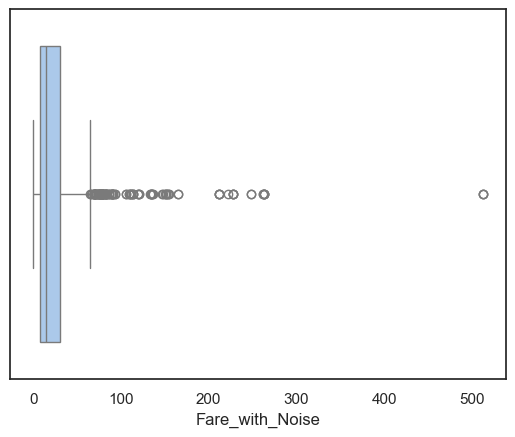

In [104]:
sns.boxplot(df, x="Fare_with_Noise")

Because the observations in the selected dataset are independent of one another, smoothing or aggregation-based methods are not appropriate for noise handling.
Based on the boxplot, the feature contains a substantial number of outliers; therefore, I used the IQR criterion to handle noise by replacing values outside the range $[Q1 - 1.5*IQR, \, Q3 + 1.5*IQR]$ with the corresponding boundary values.

In [105]:
Q1 = df["Fare_with_Noise"].quantile(0.25)
Q3 = df["Fare_with_Noise"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["Fare_Clean"] = df["Fare_with_Noise"].clip(lower=lower, upper=upper)

In [106]:
# Show at most 5 rows that `Fare_with_Noise` doe not equal ot `Fare_Clean`
filtered_df = df[df["Fare_with_Noise"] != df["Fare_Clean"]][["PassengerId", "Fare_with_Noise", "Fare_Clean"]]
filtered_df.head(5)

,PassengerId,Fare_with_Noise,Fare_Clean
1,2,71.214592,64.999746
27,28,263.186697,64.999746
31,32,147.441261,64.999746
34,35,82.579551,64.999746
52,53,76.392814,64.999746


<Axes: xlabel='Fare_Clean'>

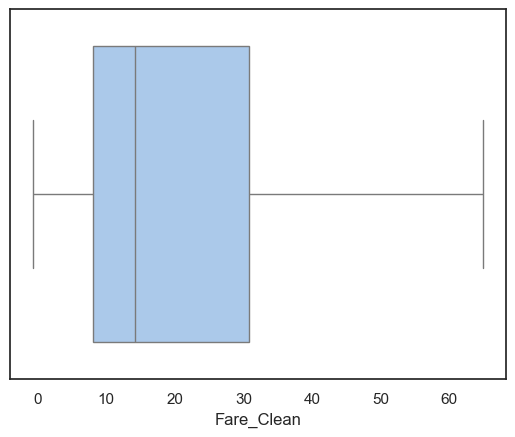

In [107]:
sns.boxplot(df, x="Fare_Clean")

---

# Step 3: Outlier Detection and Handling
1. Detect outliers in at least one numerical feature using:
    - Z-score method or
    - Visualization (boxplot)
2. Handle outliers by:
    - Removing them or
    - Transforming the feature
3. Justify your decision in 1–2 sentences.